In [1]:

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/CVDL'
dumps_path =  f"{root_path}/dumps/"
dataset  = f"{root_path}/dataset/"

!cp "$root_path/modules/lib.py" .
!cp "$root_path/modules/plots.py" .
!cp "$root_path/modules/metrics.py" .


Mounted at /content/drive


# Imports

In [27]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
import importlib
from datetime import datetime

from keras.initializers import glorot_uniform

import lib
import plots
import metrics

root_path = '/content/drive/MyDrive/CVDL'
dumps_path =  f"{root_path}/dumps/"
dataset  = f"{root_path}/dataset/"


# Parameters

In [7]:
# Deafault Res: 606x468 (ar 101 : 78)

# Tested Res's:
# 224x160 (ar 7 : 5)
# 384x288

resx = 224
resy = 160

seed = 42

params = {
          'x':resx,                                
          'y':resy,                                
          'batch_size': 16,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 1e-4,                      
          'momentum': 0.98,                        
          'nEpoches': 50,                        
          }



ratio_test = 0.8
ratio_val  = 0.9

lib.create_dump([params, seed], dumps_path + "params_du")


type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

# get name of file imgs
imgs_list_path = os.listdir(path_img)

# Data loading 

In [ ]:
# LOAD & SPLIT DATA ============================================================
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, f"{dumps_path}splitted_data_{resx}x{resy}")

#Loading Data from Pickle

In [28]:
dataset_list = pickle.load(open( f"{dumps_path}splitted_data_{resx}x{resy}", "rb" ))
#dataset_list = pickle.load(open( f"{dumps_path}dataset_pat_split", "rb" ))

#Data Augmentation

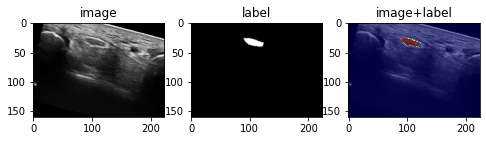

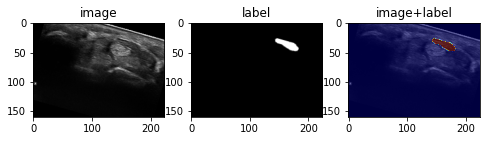

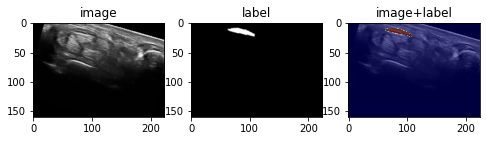

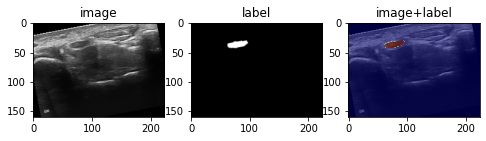

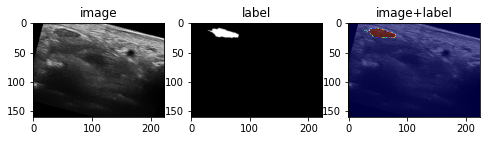

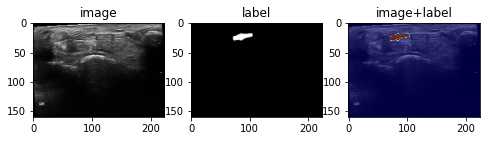

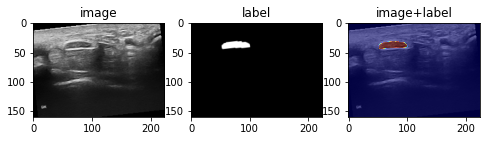

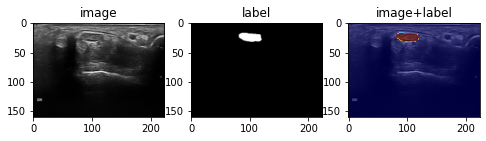

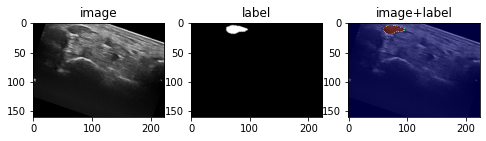

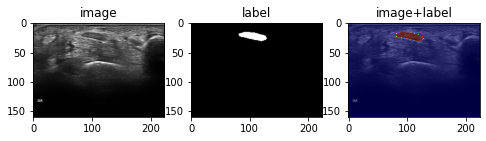

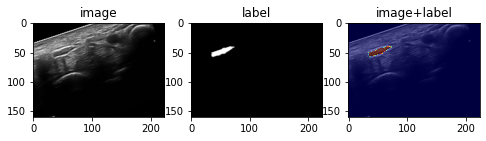

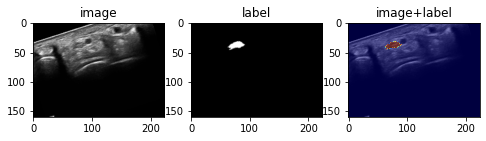

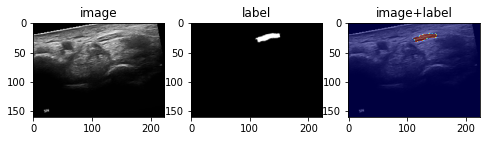

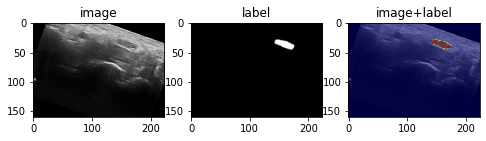

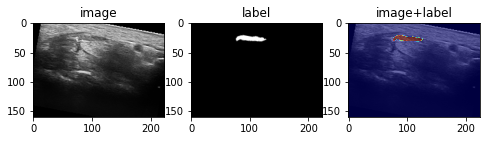

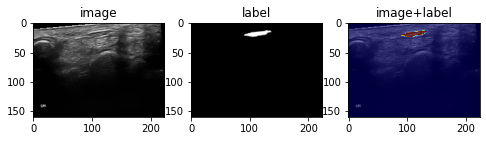

In [9]:

# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

# Model definition & training

In [10]:
from tensorflow.keras.losses import binary_crossentropy

#map function
def clamp(n):
    if n < 0: return 0.0
    elif n > 1: return 1.0
    else: return n

# Dice Coefficient
# source: https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
def dice(output, target, loss_type='sorensen', axis=(1, 2, 3), smooth=1e-7):
  inse = tf.reduce_sum(output * target, axis=axis)
  
  if loss_type == 'jaccard':
      l = tf.reduce_sum(output * output, axis=axis)
      r = tf.reduce_sum(target * target, axis=axis)
  elif loss_type == 'sorensen':
      l = tf.reduce_sum(output, axis=axis)
      r = tf.reduce_sum(target, axis=axis)
  else:
      raise Exception("Unknow loss_type")

  dice = (2. * inse + smooth) / (l + r + smooth)
  #dice = clamp(tf.reduce_mean(dice, name='dice'))
  dice = tf.reduce_mean(dice, name='dice')
  
  return dice

# IoU Coefficient
# source: https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
def iou(output, target, threshold=0.5, axis=(1, 2, 3), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the
    similarity of two batch of data, usually be used for evaluating binary image segmentation.
    The coefficient between 0 to 1, and 1 means totally match.

    Notes
    ------
    - IoU cannot be used as training loss, people usually use dice coefficient for training, 
      IoU and hard-dice for evaluating.
    """
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
    
    batch_iou = (inse + smooth) / (union + smooth)
    #iou = clamp(tf.reduce_mean(batch_iou, name='iou'))
    iou = tf.reduce_mean(batch_iou, name='iou')
    return iou  # , pre, truth, inse, union

# Dice Loss
def dice_loss(output, target):
  return 1. - dice(output, target)

# BCE-Dice Loss
# source: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch#BCE-Dice-Loss
def bce_dice_loss(output, target):
    return binary_crossentropy(output, target) + dice_loss(output, target)

In [12]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)

    numerator = 2. * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    dice = (numerator + smooth) / (denominator + smooth)

    return dice

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [13]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint

params['learningRate'] = 0.001
params['nEpoches'] = 100   

# -- Available archs --
# unet
# doubleunet
arch_name = 'doubleunet'
!cp "$root_path/modules/models/{arch_name}.py" .
arch = importlib.import_module(arch_name)

input_size = (resy, resx, 1)

if arch_name == 'doubleunet':
  model = arch.build_model(input_size)
else:
  initializer = glorot_uniform() # -> unet/ lightweight only
  model = arch.build_model(initializer,input_size)


#model.summary()

In [29]:
# Model savepath
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
model_weights = f"{root_path}/dataset/results/models/{arch_name}_{current_time}"

# Default loss, metric
#loss = 'binary_crossentropy'
#metric = 'accuracy'

#loss = metrics.dice_loss
#metric = metrics.dice

loss = dice_loss
metric = dice


train_history, model = lib.train(model_weights, params, model, loss, metric, train_generator, val_generator)

train_figure = plots.plot_train_metric(train_history, params['nEpoches'], "dice")

plt.show()

Epoch 1/100


KeyboardInterrupt: ignored

In [30]:
model_weights = '/content/drive/MyDrive/CVDL/dataset/results/models/doubleunet_13:55:43'
model.load_weights(model_weights)

# Testing results

In [33]:
evaluate_df = model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict = True)

2/2 [==============================] - 2s 162ms/step - loss: -0.1962 - dice: 1.1984


In [56]:
from tensorflow.keras.preprocessing.image import img_to_array
import copy

test_image = dataset_list[0]['test'][10,:,:,:]
test_mask = dataset_list[1]['test'][10,:,:,:]

#mean_ = np.mean(test_image)
#test_image = test_image - mean_
#std = np.std(test_image)
#test_image = test_image/std

#test_image = test_image / 255.0
#test_mask = test_mask / 255.0

test_image = img_to_array(test_image)
test_image = test_image.reshape((1, test_image.shape[0],
                                    test_image.shape[1],
                                    test_image.shape[2]))

#test_image = cv2.merge((test_image,test_image,test_image))
#test_mask = cv2.merge((test_mask,test_mask,test_mask))
#model.predict_classes(X_test)

# prediction
prediction = model.predict(test_image)
# copia per ridefinire la segmentazione ar di intensità dei valori
pred = copy.copy(prediction[0,:,:,0])

pred[pred >= threshold] = 1
pred[pred < threshold] = 0

test_results = {
  'test_image': test_image,
  'test_mask': test_mask,
  'pred_image': prediction,
  'pred_mask': pred
  }

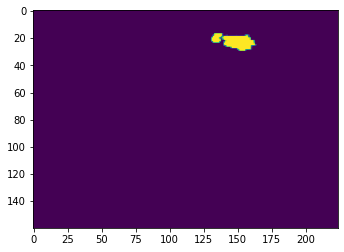

In [58]:
plt.imshow(prediction[0,:,:,0])

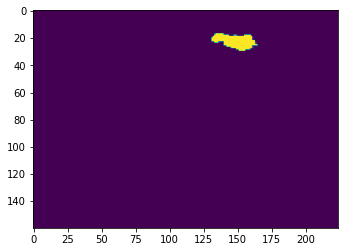

In [59]:
plt.imshow(prediction[0,:,:,1])

In [72]:
import numpy
import keras
import keras.backend as K
import tensorflow as tf

smooth = 1. # Used to prevent the denominator from 0.
def dice(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true) # Extend y_true to one dimension.
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1. - dice(y_true, y_pred)

print(dice(output,target))

tf.Tensor(0.8729797, shape=(), dtype=float32)


In [ ]:
import numpy
import keras
import keras.backend as K
import tensorflow as tf

smooth = 1. # Used to prevent the denominator from 0.
def dice(y_true, y_pred):
    y_true_f = K.flatten(y_true) # Extend y_true to one dimension.
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1. - dice(y_true, y_pred)

In [74]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 224, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 160, 224, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 224, 64) 1792        concatenate[0][0]                
______________________________________________________________________________________________

In [80]:
import pandas as pd
def get_preditcions(test_image, test_mask, params, model, threshold):

  #mean_ = np.mean(test_image)
  #test_image = test_image - mean_
  #std = np.std(test_image)
  #test_image = test_image/std

  #test_image = test_image / 255.0
  #test_mask = test_mask / 255.0

  test_image = img_to_array(test_image)
  test_image = test_image.reshape((1, test_image.shape[0],
                                      test_image.shape[1],
                                      test_image.shape[2]))

  #test_image = cv2.merge((test_image,test_image,test_image))
  #test_mask = cv2.merge((test_mask,test_mask,test_mask))
  #model.predict_classes(X_test)

  # prediction
  prediction = model.predict(test_image)
  # copia per ridefinire la segmentazione ar di intensità dei valori
  pred = copy.copy(prediction[0,:,:,1])

  pred[pred >= threshold] = 1
  pred[pred < threshold] = 0

  test_results = {
    'test_image': test_image,
    'test_mask': test_mask,
    'pred_image': prediction,
    'pred_mask': pred
    }
  return test_results           

def get_results(dataset_list, params, model, threshold):

  results = {}    # all metrics per image
  length_test = len(dataset_list[0]['test'])

  for image_index in range (length_test):
      test_image = dataset_list[0]['test'][image_index,:,:,0]
      test_mask = dataset_list[1]['test'][image_index,:,:,0]
      test_results = get_preditcions(test_image, test_mask, params, model, threshold)
      results[image_index] = {'dice': lib.dice(test_mask, test_results["pred_mask"])}
  
  results_df = pd.DataFrame(results).transpose()  
  avgs = {'dice': results_df['dice'].mean()}      # metrics averages

  return results_df, avgs


In [81]:
# Set the threshold for predictions
threshold = 0.5

results_df, avgs = get_results(dataset_list, params, model, threshold)
print(results_df)
print(avgs)

        dice
0   0.927697
1   0.948805
2   0.968220
3   0.955121
4   0.847291
5   0.954604
6   0.932761
7   0.871017
8   0.000000
9   0.944099
10  0.839314
11  0.898734
12  0.845188
13  0.917829
14  0.933977
15  0.912500
16  0.930931
17  0.938889
18  0.906031
19  0.961039
20  0.952141
21  0.945455
22  0.931587
23  0.925547
24  0.842742
25  0.775439
26  0.786260
27  0.908730
28  0.909457
29  0.880184
30  0.769231
31  0.922374
32  0.870886
33  0.894942
34  0.954887
35  0.931034
36  0.913793
37  0.929577
38  0.949840
39  0.941176
40  0.913444
41  0.918580
42  0.814305
43  0.565757
44  0.924000
45  0.783898
46  0.914498
47  0.927215
48  0.945946
49  0.926662
50  0.908486
51  0.939040
52  0.932110
53  0.907675
54  0.870285
55  0.821757
{'dice': 0.8818391307621986}


In [82]:
res = results_df.loc[(results_df['dice'] < 0.60)]
print(res)

num = res['dice'].count()
den = results_df['dice'].count()

print(num/den)

        dice
8   0.000000
43  0.565757
0.03571428571428571


testing accuracy: 0.9968191964285714
testing dice: 0.56575682382134


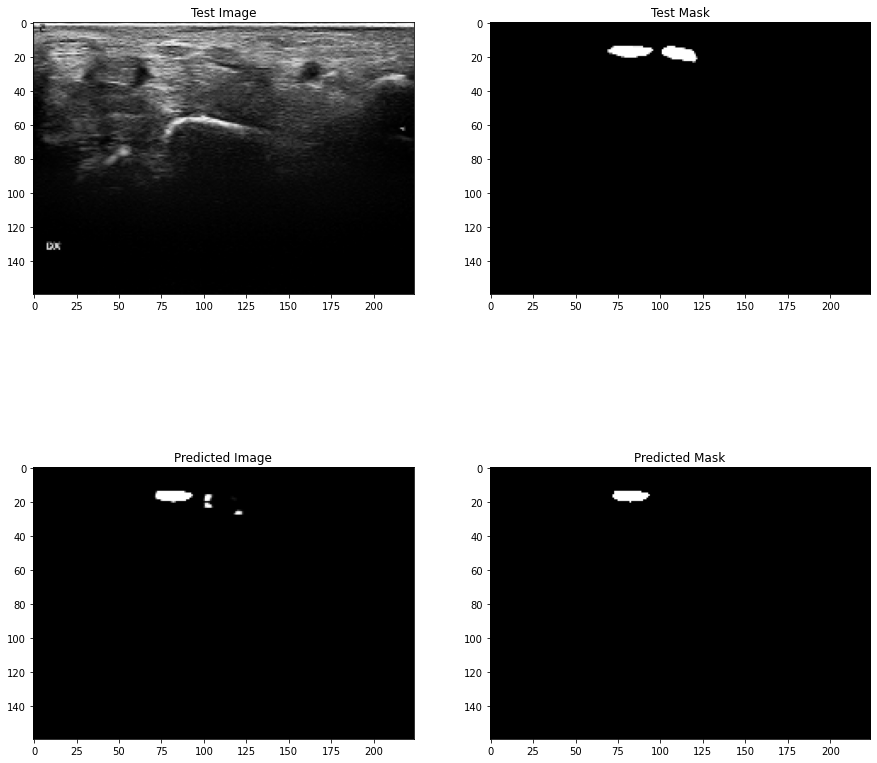

In [87]:
# Set the threshold for predictions
threshold = 0.5

# Select the image on which make 
image_index = 43
test_image = dataset_list[0]['test'][image_index,:,:,0]
test_mask = dataset_list[1]['test'][image_index,:,:,0]

test_results = get_preditcions(test_image, test_mask, params, model, threshold)

print("testing accuracy:", lib.accuracy(test_mask, test_results["pred_mask"]))
print("testing dice:", lib.dice(test_mask, test_results["pred_mask"]))

results_figure = plots.plot_test_results(test_results)
plt.show()